In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import cv2
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [14]:

def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        #target["image_id"] = img_id
        
        return target


In [15]:
images_dir = "mask_detector/data/sample_images/"
imgs = list(sorted(os.listdir(images_dir)))

In [16]:
labels_dir = "mask_detector/data/sample_annotations/"
labels = list(sorted(os.listdir(labels_dir)))

In [17]:
def plot_image(img, annotation):
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    labels = annotation["labels"]
    for index,box in enumerate(annotation["boxes"]):        
        xmin, ymin, xmax, ymax = box
        # Create a Rectangle patch
        if labels[index] == 0:
            color = 'r'
        if labels[index] == 1:
            color = 'g'
        if labels[index] == 2:
            color = 'y'
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=color,facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

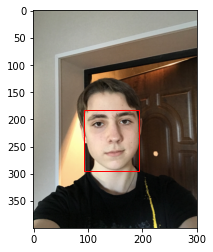

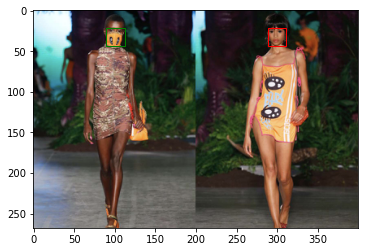

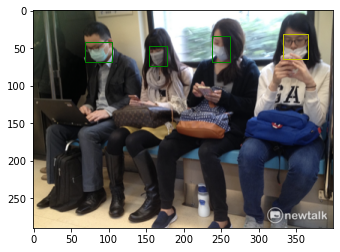

In [18]:
for image,annotation in zip(imgs,labels):
    img = Image.open(images_dir+image).convert("RGB")
    target = generate_target(labels_dir+annotation)
    plot_image(img, target)